## Advanced Network Generation

After having showed you the basic network generation functionality of Konnektor, let's go beyond that. Konnektor contains a plethora of functions, that can be used to construct, modify or analyse networks.

In the next step we will showcase this functionality by loading a set of potential ligands, that contain a charge change. Our goal here is to build up a network, that is edge efficient but seperates the charges automatically.


### Get Data
First let's load the data:

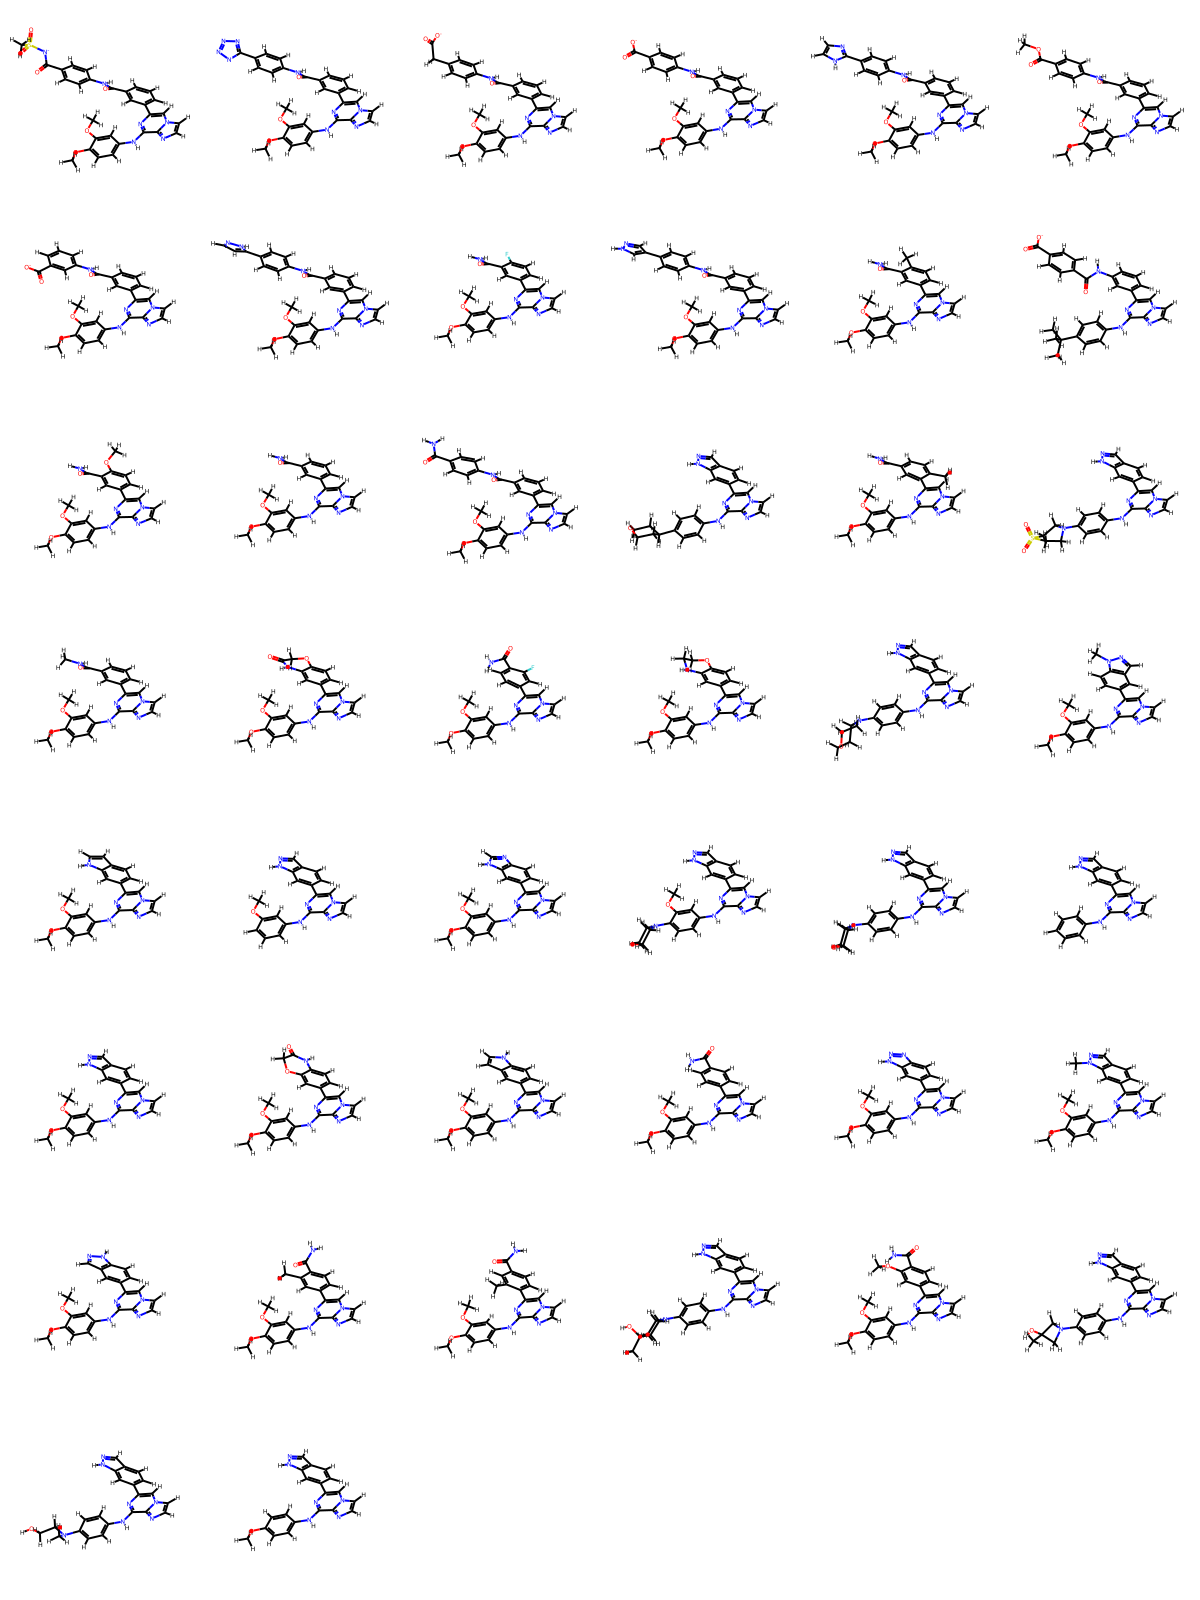

In [1]:
# Getting Data
from rdkit import Chem
from konnektor.data import get_charged_ligands

charge_components = get_charged_ligands()
Chem.Draw.MolsToGridImage([c.to_rdkit() for c in charge_components], molsPerRow=6)

### Generated the Required Scorer
Like with the real world example, we will generate the `AtomMapper` and `AtomMappingScorer` here.

Additionally to the already defined `MappingVolumeRatioScorer` we define here another very simple and crude `charge_scorer`, that captures charge changes and adds a score (please don't use in the real world). We will combine both scores into a `combo_scorer`

In [2]:
# Load AtomMapper and Scorer
# Please note that you will need to install Kartograf for this example to work!
from kartograf import KartografAtomMapper, MappingVolumeRatioScorer

mapper = KartografAtomMapper()

# Define Scorer Combination
volume_scorer = MappingVolumeRatioScorer()

from gufe import AtomMapping


def charge_scorer(atom_mapping: AtomMapping) -> float:
    mA = atom_mapping.componentA.to_rdkit()
    mB = atom_mapping.componentB.to_rdkit()
    cA = Chem.GetFormalCharge(mA)
    cB = Chem.GetFormalCharge(mB)

    dist = min(1, abs(cA - cB))
    return 1 - dist


def combo_scorer(atom_mapping: AtomMapping) -> float:
    return (1 * volume_scorer(atom_mapping) + 2 * charge_scorer(atom_mapping)) / 3

### Build A Clusterer class

Konnektor contains multiple `Clusterer` classes, for seperating `Components` in different ways. Examples include; clustering scaffold, finger print diversity, or charge.

Here we will use the `ChargeClusterer`, which will help us to seperate the molecules by its formal charge.

In [3]:
# Cluster Compounds by charge:
from konnektor.network_tools import ChargeClusterer

clusterer = ChargeClusterer()
clusters = clusterer.cluster_compounds(components=charge_components)

print("Found charges: ", clusters.keys())

Found charges:  dict_keys([-1, 0])


### Build Sub-Networks
Next we will build sub-networks for each cluster, and visualize them.

In [4]:
# Define Cluster Networks:
from konnektor.network_planners import StarNetworkGenerator

ch_radial_networker = StarNetworkGenerator(mappers=mapper, scorer=combo_scorer)
sub_networks = []
for charge, cluster in clusters.items():
    sub_network = ch_radial_networker.generate_ligand_network(cluster)
    sub_networks.append(sub_network)
used_components = [n for sub_network in sub_networks for n in sub_network.nodes]

/var/folders/fd/z1vgxzxn37b8j99qz38t2_s40000gn/T/ipykernel_21801/3269336493.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


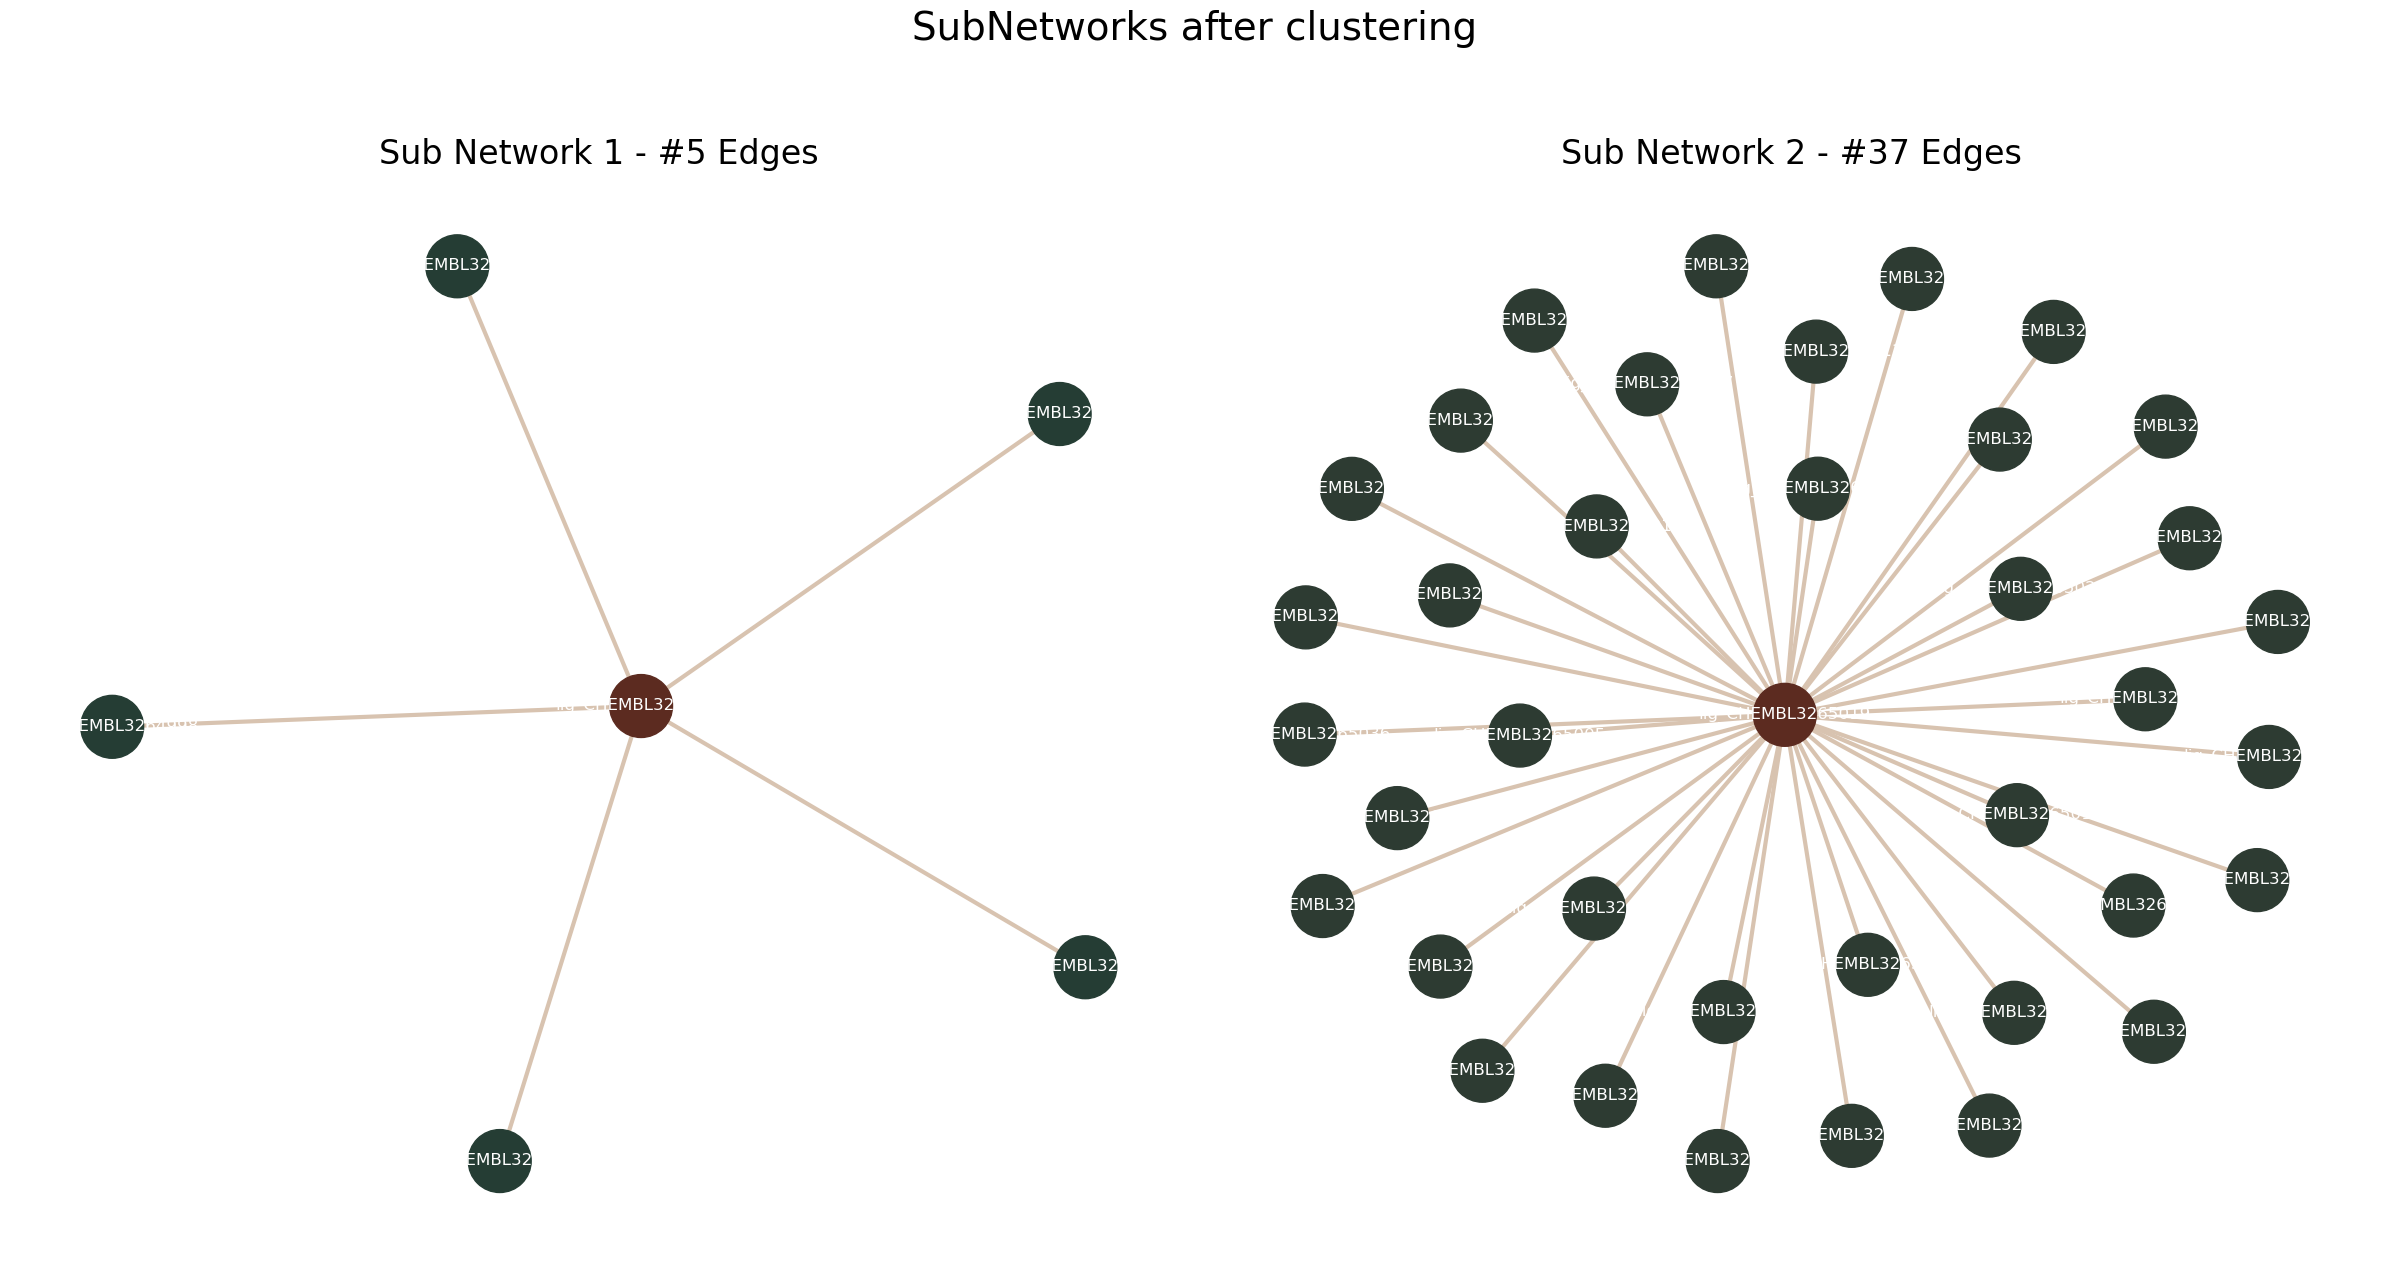

In [5]:
# NBVAL_SKIP
##Visualize sub-networks
from matplotlib import pyplot as plt
from konnektor.visualization import draw_ligand_network

fig = plt.figure(layout="constrained", figsize=[12 * 2, 12])
gs0 = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs0[1])

axes = [ax1, ax2]
i = 1
for ax, sub in zip(axes, sub_networks):
    draw_ligand_network(sub, ax=ax)
    ax.set_title(
        "Sub Network " + str(i) + " - #" + str(len(sub.edges)) + " Edges", fontsize=24
    )
    ax.axis("off")
    i += 1

fig.suptitle("SubNetworks after clustering", fontsize=28, y=1.05)
fig.tight_layout()

### Concatenate the sub-Networks to a final Network

Finally we use the concatenation functionality in Konnektor, that allows you to concatenate two or more networks.

To achieve this a special network planner class type is needed the `NetworkConcatenator`. Here we use the `MstConcatenator` which builds all possilbe edges between two networks and then selects the best scoring `n_connecting_edges` to build the final network.

In [ ]:
# NBVAL_SKIP
## Concatenate Sub-Networks
from konnektor.network_tools import concatenate_networks
from konnektor.network_planners import MstConcatenator

concatenator = MstConcatenator(
    mappers=mapper, scorer=combo_scorer, n_connecting_edges=2, n_processes=1
)

charged_starry_sky_network = concatenate_networks(
    networks=sub_networks, concatenator=concatenator
)
charged_starry_sky_network.name = "Starry Sky Network"
charged_starry_sky_network

/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/multiprocessing/queues.py", line 389, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^

This yields a __Charged Starry Sky Network__. 

Visualizing the network you can see how the network consists of two clusters connected by a few edges, reducing the number of net charge changes necessary to explore the network.

In [ ]:
# NBVAL_SKIP
from konnektor.visualization import draw_ligand_network

draw_ligand_network(
    charged_starry_sky_network,
);

#### Interactive visualization wwith the `draw_network_widget`

You can interactively explore this network, and the mappings for each edges, using the `draw_network_widget`.

In [ ]:
# NBVAL_SKIP

from konnektor.visualization import draw_network_widget

draw_network_widget(charged_starry_sky_network, show_molecules=True, show_mappings=True);

### Analyzing the generated network:

In the final step, we will compare the generated __Charged Starry Sky Network__ with alternative network layouts. 

#### Generating Additional Networks to compare to.

For our comparison we will generate a global __Star Network__ and a __Redundant MST Network__.


In [ ]:
# NBVAL_SKIP

# first let's generate the Star Network (we will use the networker from above).
ch_radial_networker = StarNetworkGenerator(
    mappers=mapper, scorer=combo_scorer, n_processes=1
)
charge_star_network = ch_radial_networker.generate_ligand_network(used_components)
charge_star_network.name = "Star Network"

# And additionally the Cyclic Network
from konnektor.network_planners import RedundantMinimalSpanningTreeNetworkGenerator

ch_rmst_networker = RedundantMinimalSpanningTreeNetworkGenerator(
    mappers=mapper, scorer=combo_scorer, n_processes=1, n_redundancy=2
)
charge_rmst_network = ch_rmst_networker.generate_ligand_network(used_components)
charge_rmst_network.name = "Redundant MST Network"

In [ ]:
# NBVAL_SKIP

from konnektor.visualization import draw_ligand_network

draw_ligand_network(
    charge_star_network,
)
draw_ligand_network(
    charge_rmst_network,
);

#### Comparing Networks

We can compare our networks using the analysis functions implemented in Konnektor.

**Checking a network is connected:**

We can check that a network is connected using the `get_is_connected` method.

**Counting the number of edges and cycles:**

We can count the number of edges in a network and the number of cycles available using the `get_component_connectivities` and `get_number_of_network_cycles` methods respectively.

**Calculating the Network cost**

We can get the cost of the network, i.e. the sum of all edge scores ($\sum^N_i 1-s^i_e$) using `get_network_cost`.

This metric gives us a rough estimate of the overalll difficulty of all the transformations in the network.

**Calculating graph robustness**

We can evaluate the robustness of a network using `get_transformation_failure_robustness`.
Here robustness checks how resiliant a network is to losing an edge. This is done by randomly removing $1%$ of the edges, evaluating if the graph is still connected and repeating this for 100 times, giving a ratio of how often the graph was still connected.

In [ ]:
# NBVAL_SKIP

import numpy as np
from konnektor.network_analysis.network_analysis import (
    get_network_cost,
    get_is_connected,
    get_number_of_network_cycles,
    get_component_connectivities,
    get_transformation_failure_robustness,
)

networks = [charge_star_network, charged_starry_sky_network, charge_rmst_network]

header_format_str = "|{:<30}|{:>22}|{:>22}|{:>22}|"
format_str = "|{:<30}|{:>22.2f}|{:>22.2f}|{:>22.2f}|"

table_str = header_format_str.format("Metric", *[n.name for n in networks]) + "\n"
table_str += header_format_str.format("-" * 30, "-" * 22, "-" * 22, "-" * 22) + "\n"
table_str += (
    header_format_str.format(
        "is connected", *[str(get_is_connected(n)) for n in networks]
    )
    + "\n"
)
table_str += (
    header_format_str.format("number of edges", *[len(n.edges) for n in networks])
    + "\n"
)
table_str += (
    header_format_str.format(
        "number of graph cycles",
        *[int(get_number_of_network_cycles(n)) for n in networks],
    )
    + "\n"
)
table_str += (
    format_str.format(
        "average node connectivity",
        *[np.mean(list(get_component_connectivities(n).values())) for n in networks],
    )
    + "\n"
)
table_str += (
    format_str.format("graph cost", *[get_network_cost(n) for n in networks]) + "\n"
)
table_str += (
    format_str.format(
        "graph robustness",
        *[get_transformation_failure_robustness(n, failure_rate=0.01) for n in networks],
    )
    + "\n"
)

from IPython.display import display, Markdown, Latex

display(Markdown(table_str))

In our comparison the __Star Network__ and the __Starry Sky Network__ have a similar *number of edges* and significantly fewer than the __Redundant MST Network__. If all transformations can be calculated succesfully in the first go, this would mean that the both the __Star Network__ and the __Starry Sky Network__ would require fewer calculations to complete.

However the *graph cost* for the __Star Network__ is significantly higher compared to the __Starry Sky Network__ and the similarly performing __Cyclic Network__. Assuming an accurate scoring metric, this means that the __Star Network__ contains higher difficulty transformations, which may require more samples to converge.

Looking at *graph robustness*, we see that for the __Star Network__ any edge failure leads to the same amount of `Component`s lost in the final ranking. The __Starry Sky Network__ seems to recover from an $1\%$ edge loss in ~ 10% of cases, which does not make it a very robust approach either. Only the __Redundant MST Network__ is able to withstand the $1\%$ edge failure without losing any `Component` in the final ranking. This robustness is an effect from the high *average node connectivity* of the __Redundant MST Network__. An additional interesting aspect of the __Redundant MST Network__ is the large generated number of cycles, which can be used for cycle closure analysis.

A larger comparison of Networks can be found in our pre-print: [Konnektor: A framework for using graph theory to plan networks for free energy calculations](https://chemrxiv.org/engage/chemrxiv/article-details/66d9b574cec5d6c1423643e4)
